In [5]:
!pip install -U openai-whisper


     ---------------------------------------- 0.0/800.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/800.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/800.5 kB ? eta -:--:--
     ------------- -------------------------- 262.1/800.5 kB ? eta -:--:--
     ----------------------- ------------ 524.3/800.5 kB 985.5 kB/s eta 0:00:01
     -------------------------------------- 800.5/800.5 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- --

In [7]:
!pip install language-tool-python


In [1]:
import os
import whisper
import pandas as pd
import numpy as np
import language_tool_python
from tqdm import tqdm
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error


In [2]:

# Load CSV
train_df = pd.read_csv("C:\\Users\\ASUS\\Downloads\\isha\\dataset\\train.csv")
print(train_df.columns)
train_df.head()

Index(['filename', 'label'], dtype='object')


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [3]:
test_df = pd.read_csv("C:\\Users\\ASUS\\Downloads\\isha\\dataset\\test.csv")
print(test_df.columns)
test_df.head()

Index(['filename'], dtype='object')


,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


In [4]:
TRAIN_AUDIO_DIR = "C:\\Users\\ASUS\\Downloads\\isha\\dataset\\audios_train"
TEST_AUDIO_DIR = "C:\\Users\\ASUS\\Downloads\\isha\\dataset\\audios_test"
TRAIN_CSV = "C:\\Users\\ASUS\\Downloads\\isha\\dataset\\train.csv"
TEST_CSV = "C:\\Users\\ASUS\\Downloads\\isha\\dataset\\test.csv"

In [5]:
model = whisper.load_model("base")

def transcribe_audio(path):
    try:
        result = model.transcribe(path)
        return result["text"]
    except Exception as e:
        print(f"Error transcribing {path}: {e}")
        return ""

In [6]:
tool = language_tool_python.LanguageTool('en-US')

def grammar_score(text):
    if not text.strip():
        return 0.0  # No transcription = worst score

    matches = tool.check(text)
    num_errors = len(matches)
    num_words = len(text.split())

    if num_words == 0:
        return 0.0

    error_rate = num_errors / num_words

    # Heuristic scoring (can be tuned)
    if error_rate > 0.25:
        return 1.0
    elif error_rate > 0.18:
        return 2.0
    elif error_rate > 0.12:
        return 3.0
    elif error_rate > 0.06:
        return 4.0
    else:
        return 5.0

In [7]:
def compute_score(transcription):
    if not transcription.strip():
        return 0.0

    matches = tool.check(transcription)
    num_words = len(transcription.split())
    num_errors = len(matches)

    grammar_errors = [m for m in matches if m.ruleIssueType == 'grammar']
    spelling_errors = [m for m in matches if m.ruleId.startswith("MORFOLOGIK")]

    # Scoring logic (tunable)
    penalty = (
        0.3 * len(grammar_errors) +
        0.2 * len(spelling_errors) +
        0.1 * (num_errors - len(grammar_errors) - len(spelling_errors))
    )

    score = 5.0 - penalty
    return max(0.0, min(5.0, score))

In [8]:
print(train_df.columns)


Index(['filename', 'label'], dtype='object')


In [12]:
model = whisper.load_model("base")  # or "small" / "medium"
tool = language_tool_python.LanguageTool("en-US")

predicted_scores = []

for filename in tqdm(train_df["filename"]):
    file_path = f"C:\\Users\\ASUS\\Downloads\\isha\\dataset\\audios_train\\{filename}"

    try:
        # 1. Transcribe
        result = model.transcribe(file_path)
        transcription = result["text"]

        # 2. Check grammar
        matches = tool.check(transcription)
        num_errors = len(matches)
        words = len(transcription.split())

        # 3. Score: you can tweak this formula to make it stricter
        score = max(0.0, 5.0 - (num_errors / words * 5.0)) if words > 0 else 0.0
        predicted_scores.append(score)

    except Exception as e:
        print(f"Error with file {filename}: {e}")
        predicted_scores.append(0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 444/444 [6:16:16<00:00, 50.85s/it]


In [13]:
print(f"🔍 Length of train_df: {len(train_df)}")
print(f"🧮 Length of predicted_scores: {len(predicted_scores)}")


🔍 Length of train_df: 444
🧮 Length of predicted_scores: 444


In [14]:
train_df["predicted_score"] = predicted_scores
train_df.rename(columns={"label": "score"}, inplace=True)

# Convert and compute correlation
train_df["score"] = train_df["score"].astype(float)
train_df["predicted_score"] = train_df["predicted_score"].astype(float)

from scipy.stats import pearsonr
pearson_corr, _ = pearsonr(train_df["score"], train_df["predicted_score"])
print(f"📊 Pearson Correlation: {pearson_corr:.4f}")

📊 Pearson Correlation: -0.1059


In [15]:
print(train_df["score"].describe())
print(train_df["predicted_score"].describe())


count    444.000000
mean       3.617117
std        1.114151
min        1.000000
25%        2.500000
50%        3.500000
75%        4.500000
max        5.000000
Name: score, dtype: float64
count    444.000000
mean       4.699564
std        0.669824
min        0.000000
25%        4.737173
50%        4.883721
75%        4.960000
max        5.000000
Name: predicted_score, dtype: float64


In [16]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

pearson_corr, _ = pearsonr(train_df["score"], train_df["predicted_score"])
mae = mean_absolute_error(train_df["score"], train_df["predicted_score"])

print(f"📊 Pearson Correlation: {pearson_corr:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")


📊 Pearson Correlation: -0.1059
📉 Mean Absolute Error (MAE): 1.3836


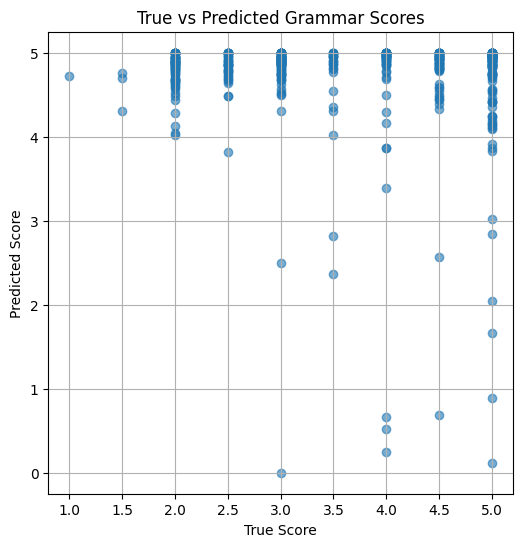

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(train_df["score"], train_df["predicted_score"], alpha=0.6)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("True vs Predicted Grammar Scores")
plt.grid(True)
plt.show()
